Jest to druga część mojego notatnika dotyczącego autoenkoderów. Opisany w niej zostanie przede wszystkim variatonal autoencoder - VAE.
Nadal bazuję na książce Deep Learning, Ian Goodfellow.

Ponadto polecam film dobrze (moim zdaniem) wyjaśniający to zagadnienie, z wieloma przydatnymi wizualizacjami: [Variatonal Autoencoders Deepia](https://www.youtube.com/watch?v=qJeaCHQ1k2w). Był dla mnie nieoceniony przy próbach zrozumienia, co się faktycznie dzieje.

# Zastosowanie VAE - generatywna sztuczna inteligencja

Co w sytuacji, gdy chcemy osiągnąć coś zupełnie innego, niż poprzednie zastosowane autoenkodery, i przejść do generatywnej AI?
Przypomina mi się w tym momencie mój projekt deep convolutional GAN, który generował zdjęcia twarzy. Tam działało to tak, że pobieraliśmy losową próbkę, nazwaną latent vector i z tej próbki generator tworzył obraz, który dla dyskryminatora miał być nieodróżnialny od prawdziwej twarzy.

Tam był latent vector, tutaj jest latent space, może to prawie to samo? W końcu nazywa się podobnie... Co jeśli byśmy spróbowali wziąć sam dekoder, zapodali mu losowy punkt z latent space i liczyli na obraz? 

Plan może nie jest zły, ale wykonanie jest fatalne. Dlaczego? Ponieważ latent space zazwyczaj nie jest uporządkowana i dla większości możliwych punktów w tej przestrzenii dekoder wytworzy bezużyteczny bełkot. 

No dobra, to spróbujmy wrzucić w enkoder zdjęcie cyfry, np. 5, zobaczyć do którego punktu w przestrzenii ukrytej zostanie zmapowane to zdjęcie, pobierzmy kilka punktów z jego najbliższego sąsiedztwa, i to podajmy dekoderowi? Znowu, plan może nie jest zły, ale nie wyjdzie - przestrzeń ukryta zupełnie nie jest uporządkowana (co najwyżej w najbliższym sąsiedztwie danych punktów, co próbował osiągnąć contractive autoencoder). Z tego powodu albo uzyskamy taki sam / bardzo podobny obraz co nasza oryginalna cyfra 5, albo znowu bezużyteczny szum.

Ale nie poddajemy się. Co w takim razie możemy zrobić, aby generować różne obrazy za pomocą autoenkoderów?
Powstrzymuje nas to, że przestrzeń ukryta jest (zazwyczaj!) nieuporządkowana i chaotyczna. Zatem rozwiązaniem jest **uporządkować latent space**. Ale jak? 

# Jak uporządkować latent space?

Na to pytanie w 2013 roku odpowiedział Diederik P. Kingma, publikując pierwszy artykuł o VAE: [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114).

Na szczęście dla nas, w 2019 roku utworzył [An Introduction to
Variational Autoencoders](https://arxiv.org/pdf/1906.02691). Jest bardzo krótkie, zaledwie 70 stron... Niemniej jest zdecydowanie bardziej czytelne niż jego oryginalna publikacja. Zawiera także obrazki :) Będzie to bardzo przydatne przy próbie wyobrażenia sobie wielu prezentowanych niżej zagadnień. Szczerze go polecam osobom, które chcą zgłębić ten temat.

Na początek pokażmy schemat, oczywiście z artykułu Diederika Kingmy, który pokazuje ogólną ideę VAE.

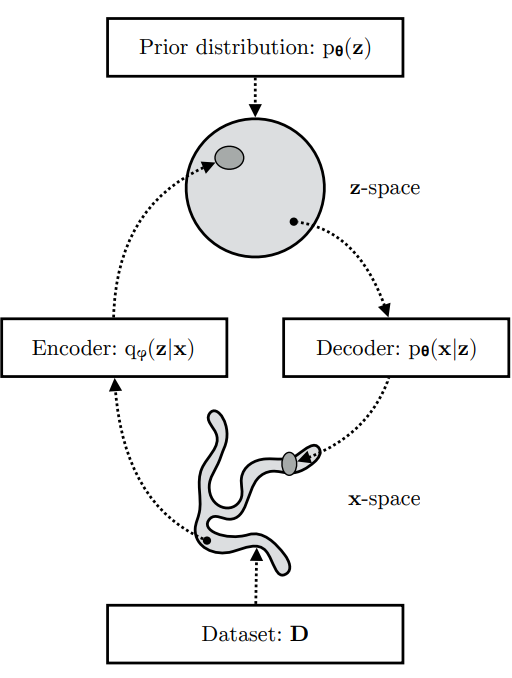

Co tu się w zasadzie dzieje?
Na początek, mamy zbiór danych znajdujący się na dole tego schematu - jest to nasz zbiór danych, na przykład zbiór odręcznie pisanych cyfr.
Zazwyczaj tego typu zbiory mają bardzo skomplikowany rozkład danych, co jest wyrażone "dziwnym" kształtem tego zbioru na rysunku.
Naszym zadaniem jest utworzenie niemalże 'ex nihilo' próbki danych, w tym przypadku obrazu, który będzie wyglądał jak obraz znajdujący się w naszym oryginalnym zbiorze danych.

VAE osiąga to w taki sposób, że enkoder uczy się mapować pomiędzy obserwowalną "przestrzenią x", której rozkład empiryczny zazwyczaj jest bardzo skomplikowany, a "przestrzenią z", której rozkład może być relatywnie prosty (na tym diagramie sferyczny). Z kolei dekoder, czyli w naszym przypadku ta generatywna część, uczy się mapowania odwrotnego - z relatywnie prostej przestrzenii `z`, do skomplikowanej przestrzenii `x`.

Dla nas ważne jest to, że rozkład w przestrzenii `z` może być relatywnie prosty - ponieważ to oznacza, że można go przybliżyć.

Po znacznie więcej szczegółów odsyłam jeszcze raz do [An Introduction to Variational Autoencoders](https://arxiv.org/pdf/1906.02691).



# Jak to zaimplementować?

No właśnie, jak? Nie znamy przecież rozkładu w przestrzeni `z`... Bez wchodzenia w szczegóły (straszne, wiem) powiem, że przyjmujemy, że rozkład w przestrzeni `z`, oznaczony na tym diagramie jako $p_\theta(z)$ jest rozkładem Normalnym z parametrami $\mu = 0, \sigma = 1$.

To założenie, w połączeniu z tym, że znamy empiryczny rozkład w przestrzeni `x`, pozwala wyznaczyć mapowanie $p_\theta(x|z)$

W takiej sytuacji brakuje nam tylko jednego elementu układanki: enkodera. Jak wyznaczyć $q_\varphi(z|x)$?
Jak wiele pozostałych rozkładów - przybliżeniem. Przyjmujemy, że jest to rozkład normalny z parametrami $\mu$ oraz $\sigma$.

Te dwa parametry, $\mu$ i $\sigma$, są parametrami, które musimy wyznaczyć - będzie je wyznaczał nasz enkoder (budujemy autoenkoder, nie zapomnijmy o tym w natłoku nowych informacji).

Z kolei dekoder będzie starał się odtworzyć obrazy zakodowane przez enkoder. Proste? Zobaczymy...

## Funkcja straty

Nie możemy wyćwiczyć naszego (ani żadnego innego) autoenkodera bez funkcji straty.

Zacytuję tutaj [Kingmę](https://arxiv.org/pdf/1906.02691) (rozdział 2.2).:
> The optimization objective of the variational autoencoder, like in other
variational methods, is the evidence lower bound, abbreviated as ELBO.
An alternative term for this objective is variational lower bound. Typically, the ELBO is derived through Jensen’s inequality. Here we will
use an alternative derivation that avoids Jensen’s inequality, providing
greater insight about its tightness.
For any choice of inference model qφ(z|x), including the choice of variational parameters φ, we have:
>
> 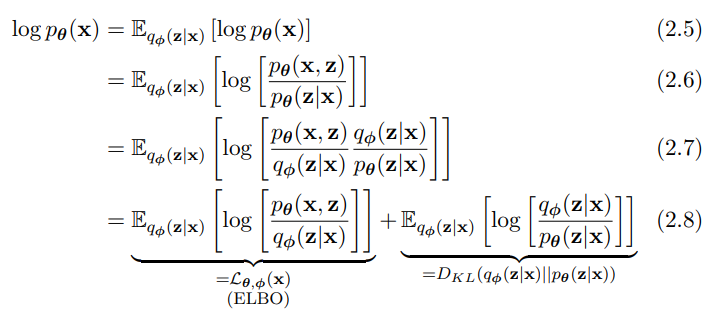



Trenując nasz model, chcemy maksymalizacji wartości $log(p_\theta(x))$

Ponieważ drugi składnik tej sumy, KL-Divergence, z definicji jest nieujemny, pierwszy składnik, czyli ELBO, jest ograniczeniem dolnym log-likelihood naszych danych.

Jak nieco dalej Kingma pokazuje w rozdziale 2.2.1:
>it can be understood that maximization
>of the ELBO $L_{\theta,\Phi}(x)$ w.r.t. the parameters θ and φ, will concurrently
>optimize the two things we care about:
>1. It will approximately maximize the marginal likelihood pθ(x).
>This means that our generative model will become better.
>2. It will minimize the KL divergence of the approximation qφ(z|x)
>from the true posterior pθ(z|x), so qφ(z|x) becomes better.

To oznacza, że trenując nasz autoenkoder chcemy maksymalizować ELBO.
Za pomocą przekształceń opisanych [w końcówce tego filmu](https://youtu.be/qJeaCHQ1k2w?si=8_WFwBBO8sPnaXrW&t=1120), można sprowadzić ELBO do następującej postaci:

$$L_{\theta,\Phi}(x) = \mathbb{E}_{q(z|x)}[log p(x|z) + log(p(z)/q(z|x)]$$
Drugi składnik tej sumy, to nic innego przemnożony przez (-1) KL-Divergence:
$$L_{\theta,\Phi}(x) = \mathbb{E}_{q(z|x)}[log p(x|z) - KL(q(z|x) || p(z))]$$
Ponieważ KL-Divergence jest tutaj liczony dla dwóch rozkładów normalnych, jeden z parametrami mi i sigma, a drugi normalny standardowy, istnieje analitycznie wyznaczone i powszechnie znane rozwiązanie.

Z kolei pierwszy składnik tej sumy odpowiada temu, jak dobrze nasz model dokonał rekonstrukcji. Dla zmiennych binarnych (a tak potraktujemy piksele w naszym zbiorze MNIST) bardzo się upraszcza i odpowiada funkcji straty binary_cross_entropy.

To oznacza, że dysponujemy gotową funkcją straty:

$$L(x, x') = BCE(x, x') - KL(q(z|x) || p(z))   $$
gdzie x - oryginalny obraz; x' - jego rekonstrukcja



## Struktura sieci

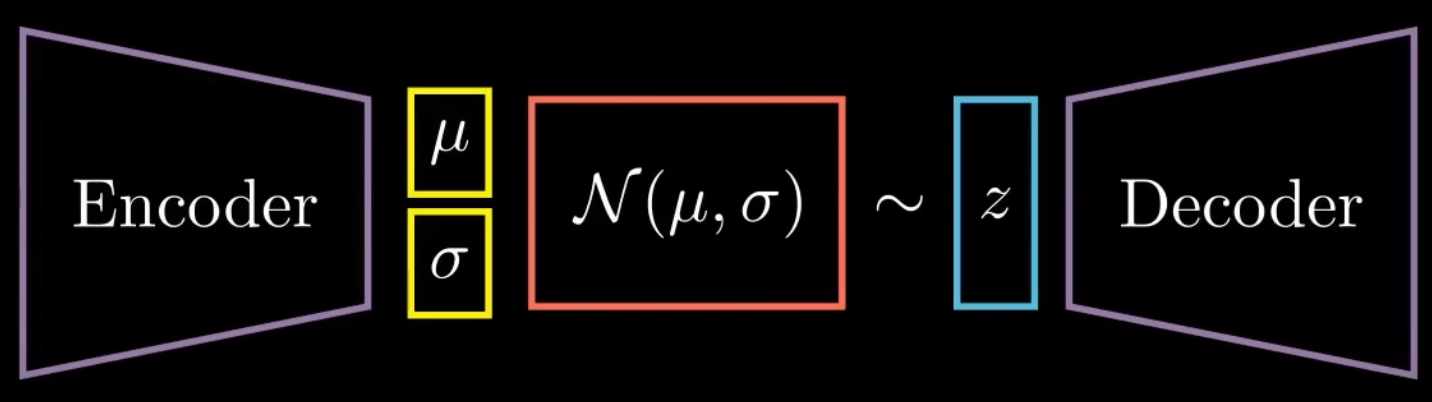

Nasz enkoder działa tak, że wyznacza parametry $\mu$ oraz $\sigma$. Następnie losuje wartość z rozkładu standardowego z tymi parametrami, i to jest punkt w przestrzenii `z`.
Następnie dekoder odkodowuje punkt z przestrzenii `z` do obrazu - w założeniu tak bliskiego oryginałowi, jak to możliwe.

Jednak występuje tutaj pewien problem **- jak to losuje wartość z rozkładu standardowego?
Przecież taka operacja nie jest różniczkowalna**, jak teraz przeprowadzić backward pass przez taką sieć?

Okazuje się, że całkiem prosto - wystarczy poza siecią wylosować liczbę z rozkładu normalnego standardowego, określaną często jako $\epsilon$, a następnie ją przeskalować:
$$z=\epsilon * \sigma + \mu$$
W tym momencie ta operacja pozostaje różniczkowalna względem parametrów $\mu$ oraz $\sigma$.
W pracach Kingmy jest to określane jako **reparametrization trick**.

## Implementacja i trening
Bierzmy się do roboty! Uzbrojeni w tą wiedzę, oraz dostęp do przedstawionych już wcześniej materiałów, spróbujmy zbudować tą sieć.

Napomknę jeszcze tylko, że zazwyczaj nie używa się samego odchylenia standardowego, lecz jego logarytmu, co ma szereg swoich zalet z obliczeniowego punktu widzenia. Warto o tym pamiętać, ponieważ w sytuacji, w której chcemy uzyskać faktyczne odchylenie standardowe/wariancję, trzeba potraktować to exponentą.

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

LATENT_DIM = 6
TRAIN_EPOCHS = 15

In [72]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=10):
        super(VAE, self).__init__()

        # Encoder (q_φ(z|x))
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder (p_θ(x|z))
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [73]:
# ELBO loss function implementation
def elbo_loss(recon_x, x, mu, logvar):
    # Reconstruction term: p_θ(x|z)
    # For MNIST with binary cross-entropy:
    BCE = F.binary_cross_entropy(
        recon_x, x.view(-1, 784),
        reduction='sum'
    )

    # KL divergence term: D_KL(q_φ(z|x)||p_θ(z))
    # Between q_φ(z|x) = N(μ, σ²) and p_θ(z) = N(0, 1)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # ELBO = reconstruction term - KL divergence
    return BCE + KLD

In [74]:
# Load MNIST dataset
full_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

train_size = int(0.85 * len(full_dataset))
test_size = len(full_dataset) - train_size

print(f"Total dataset size: {len(full_dataset)}")
print(f"Train set size : {train_size}")
print(f"Test set size: {test_size}")

gen = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Total dataset size: 60000
Train set size : 51000
Test set size: 9000


In [75]:
def test_model(model, device, test_loader):
    model.eval()
    test_loss = 0
    for images, _ in test_loader:
        images = images.to(device)
        recons, mu, logvar = model(images)
        loss = elbo_loss(recons, images, mu, logvar)
        test_loss += loss.item()
    print(f"Average test loss: {test_loss/len(test_loader.dataset):.4f}")
    model.train()
    
# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        reconstructions, mu, logvar = model(data)

        # Calculate ELBO loss
        loss = elbo_loss(reconstructions, data, mu, logvar)

        # Backward pass
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch: {epoch+1}, Average train loss: {train_loss / len(train_loader.dataset):.4f}')
    test_model(model, device, test_loader)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = VAE(latent_dim=LATENT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(TRAIN_EPOCHS):
    train(model, device, train_loader, optimizer, epoch)

# Save model
torch.save(model.state_dict(), "vae_mnist.pth")



Epoch: 1, Average train loss: 171.0023
Average test loss: 138.7936
Epoch: 2, Average train loss: 134.7800
Average test loss: 132.1948
Epoch: 3, Average train loss: 130.1647
Average test loss: 128.9123
Epoch: 4, Average train loss: 127.8014
Average test loss: 126.9362
Epoch: 5, Average train loss: 126.1285
Average test loss: 125.6626
Epoch: 6, Average train loss: 124.7645
Average test loss: 124.3499
Epoch: 7, Average train loss: 123.7065
Average test loss: 123.4625
Epoch: 8, Average train loss: 122.7381
Average test loss: 122.9383
Epoch: 9, Average train loss: 121.9798
Average test loss: 122.3116
Epoch: 10, Average train loss: 121.2418
Average test loss: 121.3926
Epoch: 11, Average train loss: 120.6167
Average test loss: 120.9096
Epoch: 12, Average train loss: 120.1366
Average test loss: 120.4444
Epoch: 13, Average train loss: 119.6330
Average test loss: 119.9651
Epoch: 14, Average train loss: 119.2176
Average test loss: 119.6559
Epoch: 15, Average train loss: 118.8439
Average test loss

Coś tam się wyćwiczyło - spróbujmy teraz dokonać inferencji na danych testowych, których model nie widział w procesie treningu

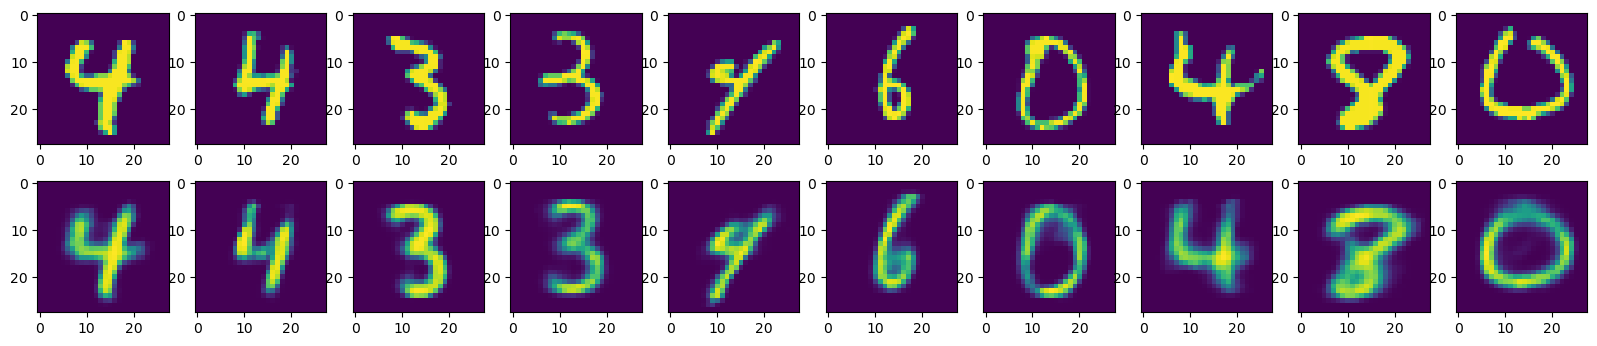

In [76]:
import matplotlib.pyplot as plt
def show_examples_on_test_data():
    model.eval()
    samples = [test_dataset[i] for i in range(10)]
    samples = [sample[0] for sample in samples] # gets rid of the label

    preds = [model(sample.to(device))[0].cpu().detach() for sample in samples]
    samples_img = [sample.view(28,28) for sample in samples]
    preds_img = [pred.view(28,28) for pred in preds]
    
    _, axs = plt.subplots(2, 10, figsize=(20,4))
    
    for (ax, img) in zip(axs[0], samples_img):
        ax.imshow(img)
    for (ax, img) in zip(axs[1], preds_img):
        ax.imshow(img)
    plt.show()
    model.train()

show_examples_on_test_data()

Poradził sobie całkiem dobrze... Jednak zwykłe odtwarzanie obrazów to nie jest jego główne zadanie.
**Zależało nam na tym, aby przestrzeń ukryta była uporządkowana**, aby można było generować z niej losowe obrazy.

Aby to sprawdzić przeprowadzimy pewien eksperyment. Wybierzemy dwa obrazy, zakodujemy je, i zobaczymy, jakim zdekodowanym obrazom bedą odpowiadać różne liniowe kombinacje ich kodów.
Wybierzemy cyfry 3 oraz 0 ponieważ intuicja podpowiada, że powinny "przechodzić w siebie" dość płynnie.


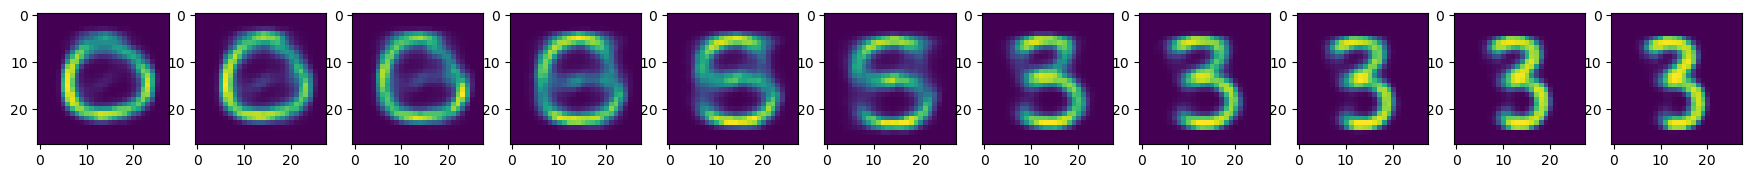

In [77]:
def show_example_blending(idx1, idx2):
    model.eval()
    img1 = test_dataset[idx1][0].to(device)
    img2 = test_dataset[idx2][0].to(device)
    mi1, logvar1 = model.encode(img1.view(784))
    mi2, logvar2 = model.encode(img2.view(784))
    alpha_vals = [0.1 * i for i in range(11)]
    preds=[]
    for alpha in alpha_vals:
        new_mi = alpha*mi1 + (1-alpha)*mi2
        new_logvar = alpha*logvar1 + (1-alpha)*logvar2
        new_z = model.reparameterize(new_mi, new_logvar)
        preds.append(model.decode(new_z).detach().cpu())
    fig, axs = plt.subplots(1, 11, figsize=(22,2))
    for (ax, img) in zip(axs, preds):
        ax.imshow(img.view(28,28))
    model.train()
    plt.show()
       
show_example_blending(2, 9) 

Sukces! **Uzyskaliśmy sytuację, w której nasza przestrzeń ukryta jest nie tylko uporządkowana, lecz także ciągła**. Jest to sytuacja, której nie doświadczymy z żadnym innym zbudowanym wcześniej autoenkoderem.

Przetestujmy to jeszcze dla kilku różnych, losowo wybranych obrazów.


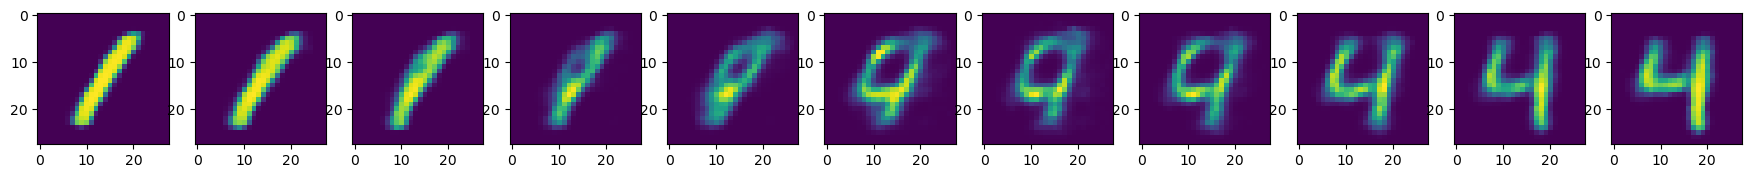

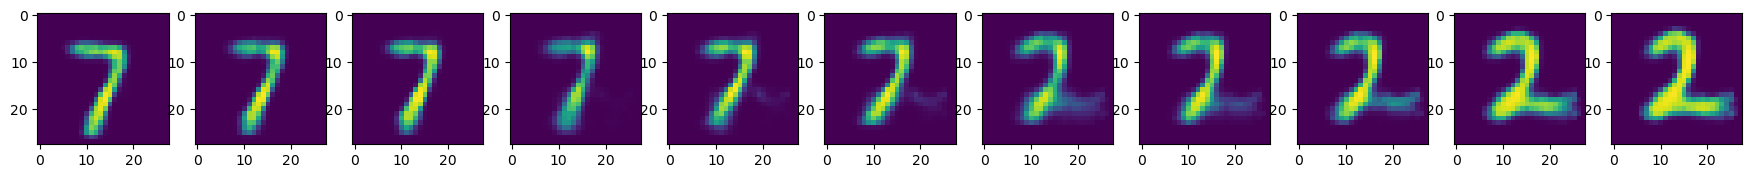

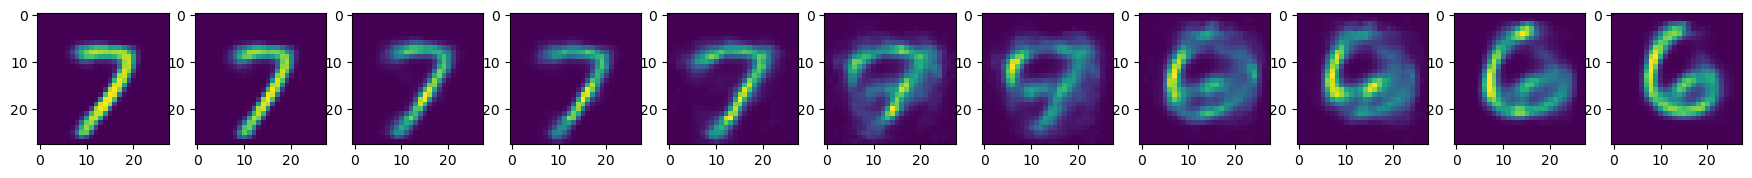

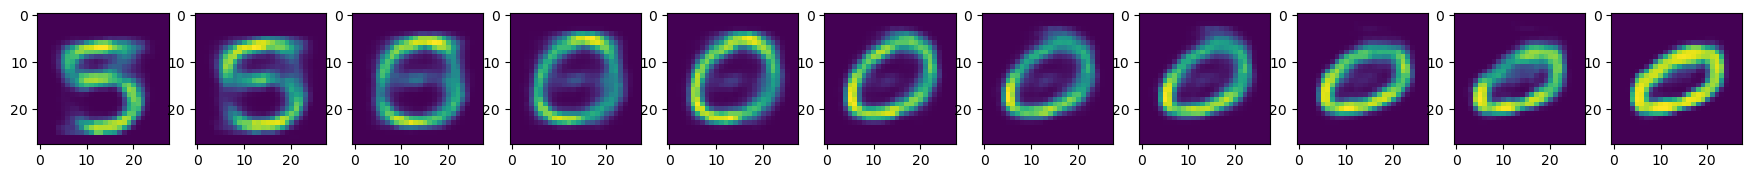

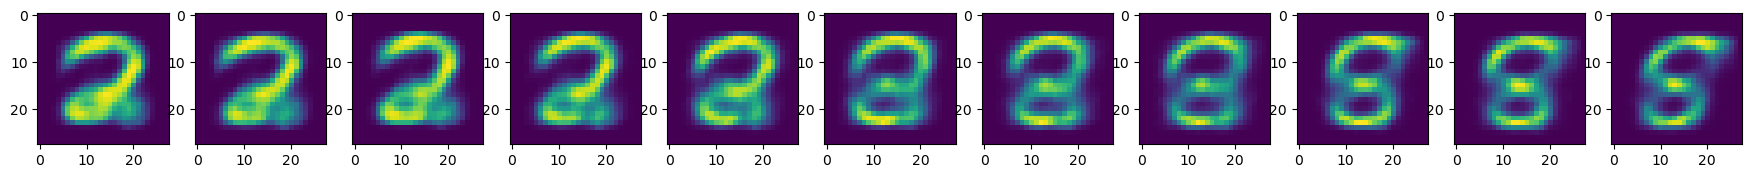

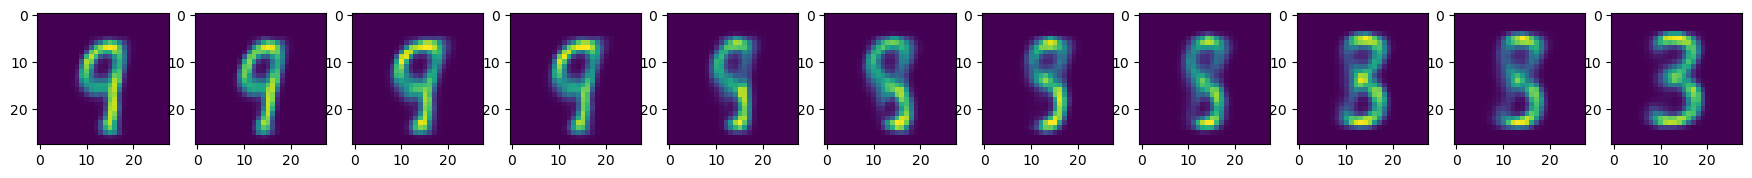

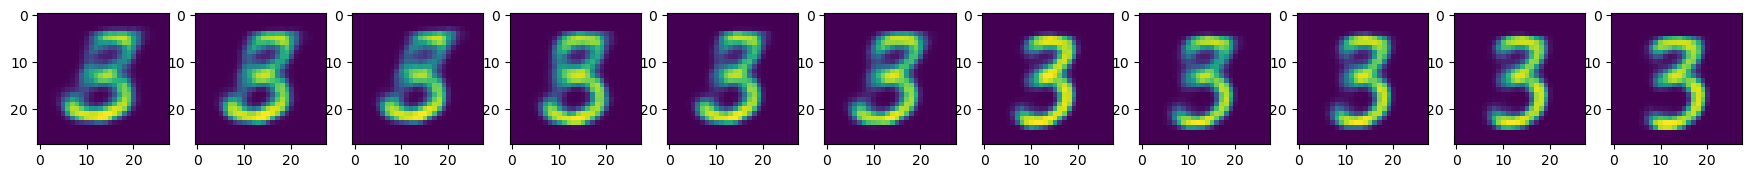

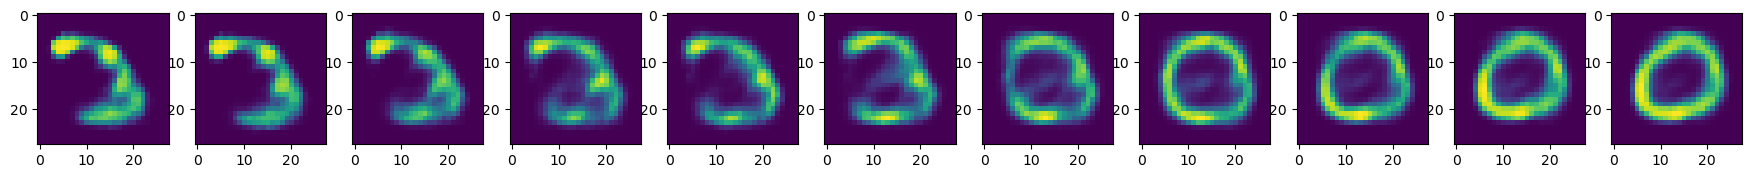

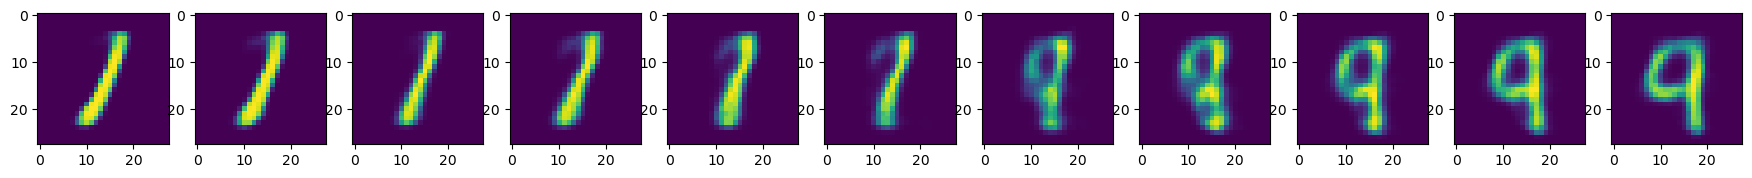

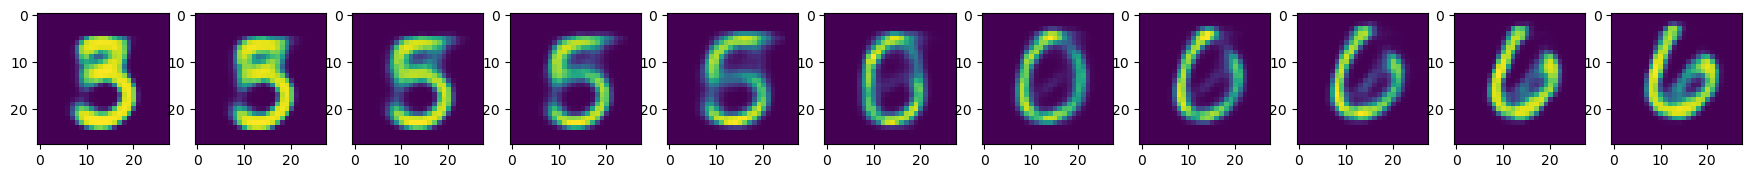

In [78]:
def show_more_blending_examples(n=5):
    for i in range(n):
        a = torch.randint(len(test_dataset), size=(1,))
        b = torch.randint(len(test_dataset), size=(1,))
        show_example_blending(a, b)
show_more_blending_examples(10)

Nie dla wszystkich cyfr wygląda to równie spektakularnie, lecz nie można odmówić tego, że działa.
Owszem, niektóre z tych obrazów nic sobą nie reprezentują bo są takim złączeniem dwóch cyfr, że nie widać w tym żadnej.

Jednak budzi to nadzieję, że będziemy mogli generować naszym modelem faktyczne obrazy.

# Generowanie obrazów

## Generowanie "ex-nihilo"
Na początek spróbujmy faktycznej generatywnej SI - to znaczy takiej, która tworzy dane nie posiadając żadnego wejścia. Aby to osiągnąć będziemy losować punkty z przestrzenii ukrytej i odkodować je do obrazów. Zobaczymy, co z tego wyjdzie.

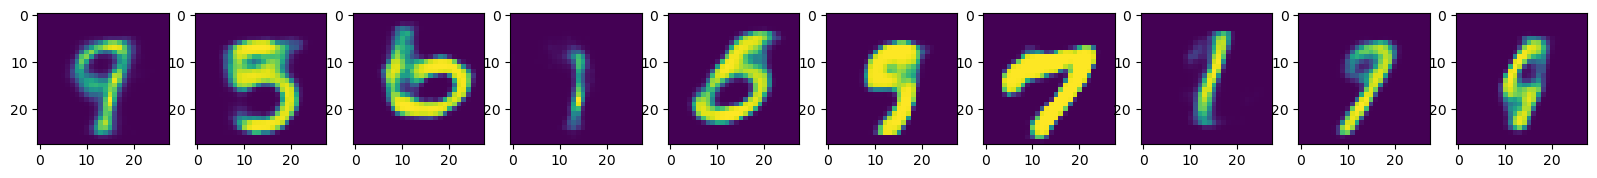

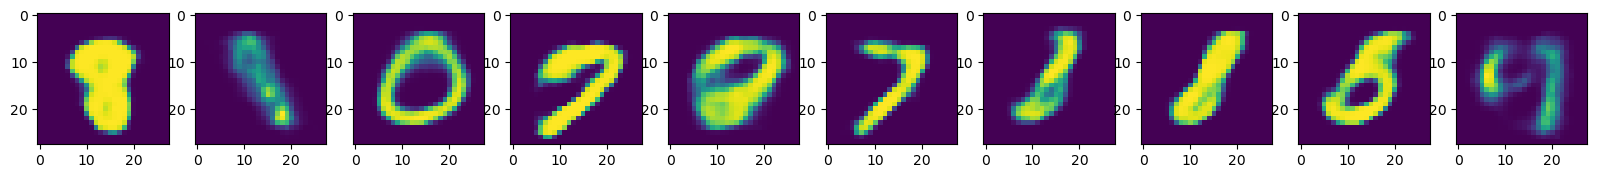

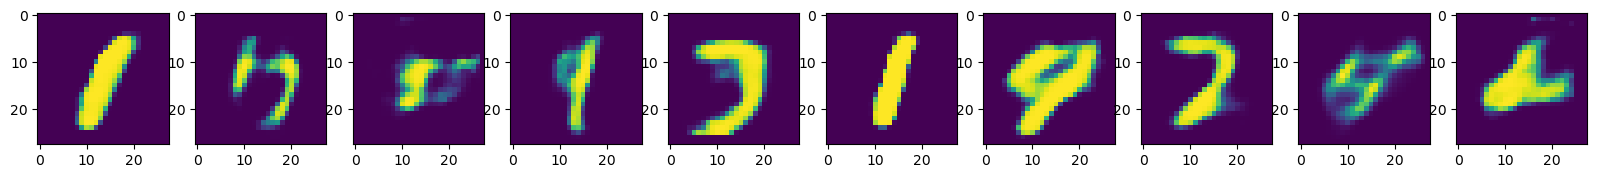

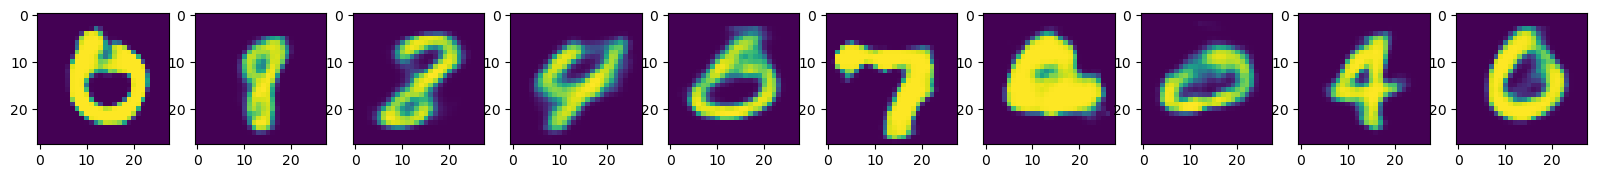

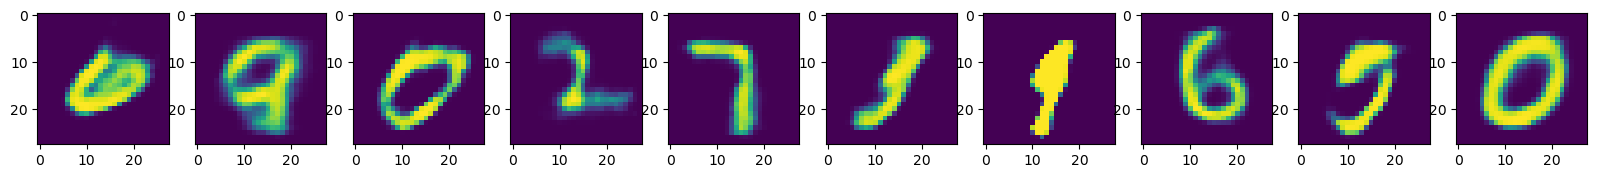

In [79]:
def generate_images(n=5, gen_mu=0, gen_std=1):
    model.eval()
    for i in range(n):
        all_mu = torch.normal(mean=gen_mu, std=gen_std, size=(10, LATENT_DIM), device=device)
        all_logvar = torch.normal(mean=gen_mu, std=gen_std, size=(10, LATENT_DIM), device=device)
        _, ax = plt.subplots(1, 10, figsize=(20,2))
        for i in range(10):
            temp_mi = all_mu[i]
            temp_logvar = all_logvar[i]
            temp_z = model.reparameterize(temp_mi, temp_logvar)
            ax[i].imshow(model.decode(temp_z).detach().cpu().view(28,28))
        plt.show()
    model.train()
generate_images()

Wybierając całkowicie losowe (generowane z wykorzystaniem rozkładu normalnego) punkty w przestrzenii `z` uzyskaliśmy obrazy, na których zdecydowana większość to albo faktyczne cyfry, nawet jeśli nieco zniekształcone, albo coś, co przynajmniej je przypomina.

*Tutaj sporo zależy od wymiaru przestrzenii ukrytej - gdy na początku próbowałem z 20 czy 10 wymiarami, większość obrazów to nie były cyfry. Z kolei dla 6 wymiarów większość obrazów to są cyfry. Niemniej z powodu zmniejszenia liczby wymiarów rekonstrukcje są nieco bardziej rozmazane. Jest to cena którą można zapłacić za lepsze zdolności generatywne tego modelu - w końcu po to jest budowany.*

Zaradzono temu problemowi w nowszych, bardziej skomplikowanych wersjach VAE (tutaj omawiana jest uproszczona wersja oryginalnego VAE zaproponowana przez Kingmę w 2013). Trzeba pamiętać, że są to same początki generatywnej sztucznej inteligencji.


## Generowanie obrazów podobnych do obrazów rzeczywistych
Teraz trochę rozjedziemy się z definicją generatywnej SI, ponieważ zapewnimy jej wejście - oryginalne zdjęcie ze zbioru testowego. Użyjemy po prostu pierwszego zdjęcia ze zbioru, czyli cyfry 4 (zbiór danych jest dzielony na treningowy i testowy zawsze w ten sam sposób).

Po co to zrobimy? Aby zakodować ten obraz do przestrzenii `z` a następnie pobrać losowe punkty z jego najbliższego sąsiedztwa w tej przetrzenii. Intuicja podpowiada, że powinniśmy wtedy uzyskać obrazy podobne do oryginalnej cyfry. Im dalej będą się znajdowały wybierane punkty od oryginalnego zakodowania naszej cyfry 4, tym bardziej między sobą powinny się różnić uzyskane rekonstrukcje. Sprawdźmy to!


In [80]:
new_gen = torch.Generator(device=device)
new_gen.manual_seed(42)
def generate_similar(img, n=5, added_mu=0, added_std=0.5):
    model.eval()
    mu, logvar = model.encode(img.view(-1, 784).to(device))
    new_mu = torch.normal(mean=added_mu, std=added_std, size=(n, *mu.shape), device=device, generator=new_gen)
    new_logvar = torch.normal(mean=added_mu, std=added_std, size=(n, *logvar.shape), device=device, generator=new_gen)
    new_mu += mu
    new_logvar += logvar
    
    new_z = model.reparameterize(new_mu, new_logvar)
    batch_preds = model.decode(new_z)
    preds = [pred.view(28,28).detach().cpu() for pred in batch_preds]
    _, axs = plt.subplots(1, n, figsize=(2*n, 2))
    for (img, ax) in zip(preds, axs):
        ax.imshow(img)
    plt.show()
    model.train()


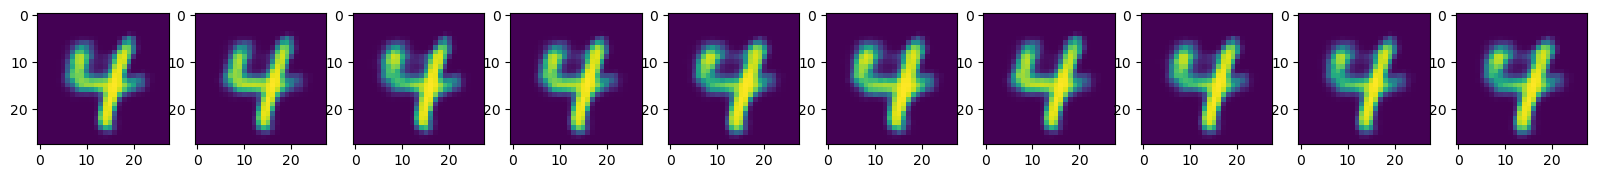

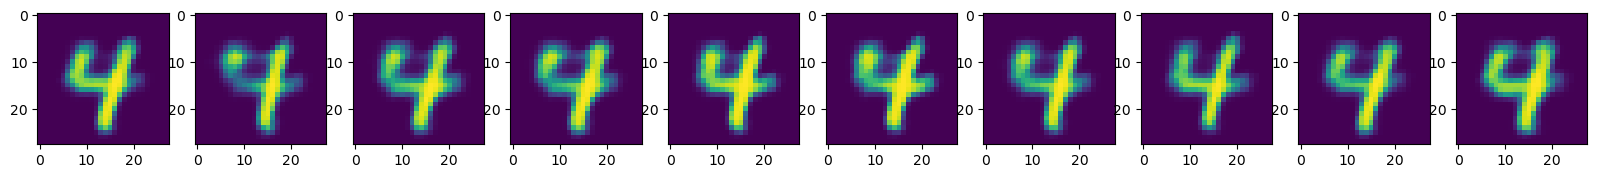

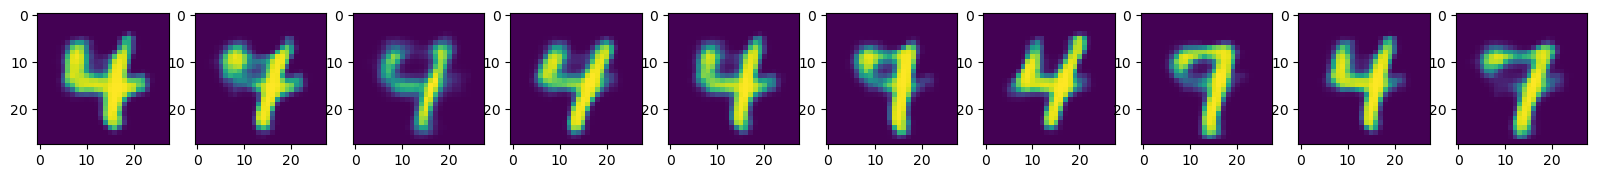

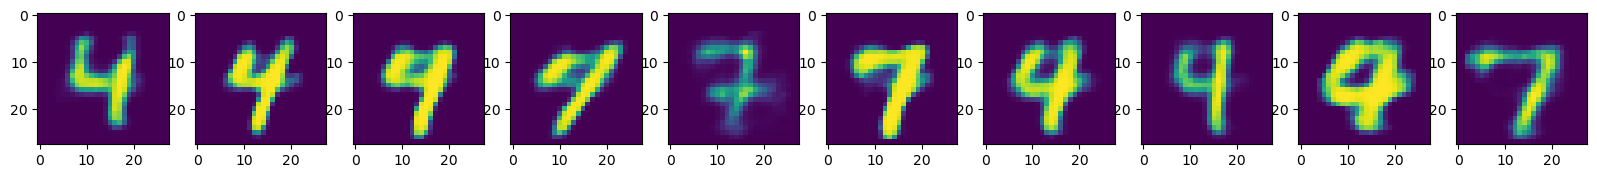

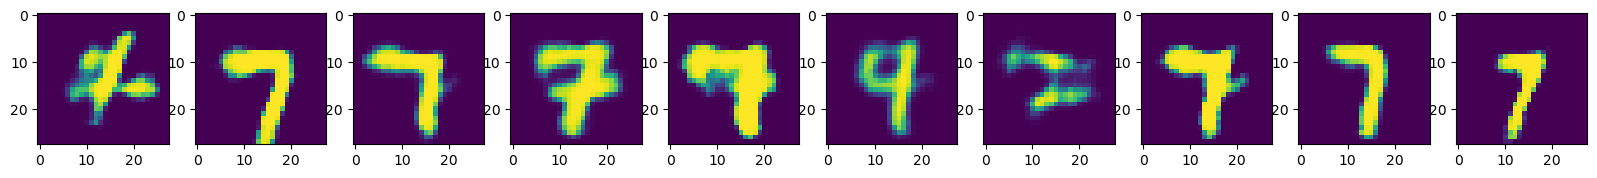

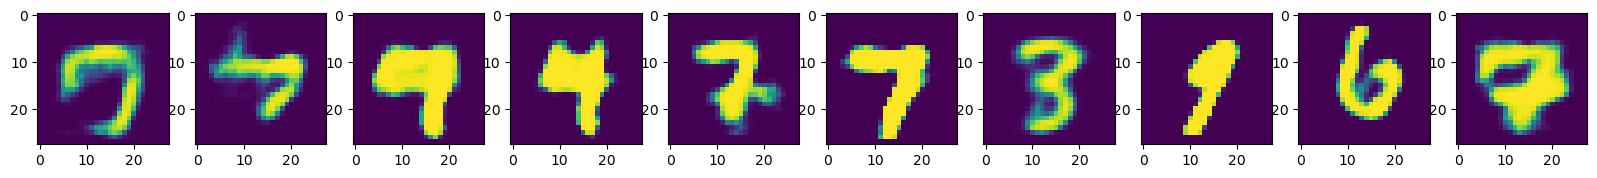

In [81]:
different_stds = [0.1, 0.2, 0.5, 1, 1.5, 2]

for temp_std in different_stds:
    generate_similar(test_dataset[0][0], added_std=temp_std, n=10)

Powyżej pokazano próby odkodowania różnych punktów w przestrzeni `z`, które powstały poprzez dodanie do oryginalnego punktu coraz silniejszego szumu (generowanego z coraz większym odchyleniem standardowym).

Dla najsłabszego szumu wszystkie wygenerowane obrazy wyglądają bardzo podobnie - jest to zgodne z oczekiwaniami. W miarę jak szum się wzmacnia, zaczyna być widać czwórki o coraz bardziej odmiennych kształtach. Niektóre obrazy nawet przechodzą w inne cyfry (najczęściej w 9 lub 7). Oczywiście są też takie, które nie wyglądają jakby reprezentowały cokolwiek konkretnego, jednak w zdecydowanej większości są to cyfry.

Zamierzony efekt najlepiej widać w drugim oraz trzecim wierszu - w znacznej większości te cyfry nadal są czwórką, ale czwórką o różnych kształtach, grubościach krawędzi...

Co prawda w tym przypadku to przestaje być generatywna AI, ponieważ wymaga zdjęcia oryginalnej cyfry - niemniej jest to całkiem satysfakcjonujące, gdy w końcu działa :)